In [1]:
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from majortrack import MajorTrack
import multiprocessing as mp
import time
import random
from collections import Counter
import pandas as pd
import matplotlib.dates as mdates
from scipy import stats
from functools import partial
import numpy as np
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import pickle

### Description

In this notebook we analyze the overlap of static communities detected on the cumulative network, respect to temporary communities detected on 4 monthly windows.

The differences between consecutive communities are firstly observed with Major Track package (not used for the final paper).

In [18]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 12, 14, 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
sys.path.insert(1,'../helpers')
import destino

In [5]:
#Monthly splitted users communities (com_of_user) are calculated 
# on notebooks analogous to "community_detection.ipynb"
periods=['Jan-Feb','March','April','May']
alphab=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q',
        'R','S','T','U','V','W','X','Y','Z','AA','AB','AC','AD','AE','AF','AG']
reso='1'
f_lst=['data/com_of_user_letters_'+reso+'_30_01may.pickle',
       'data/com_of_user_letters_'+reso+'_30_2may.pickle','data/com_of_user_letters_'+reso+'_30_3may.pickle',
       'data/com_of_user_letters_'+reso+'_30_4may.pickle']

s_t=time.time()
pool=mp.Pool(4)
LC=partial(destino.load_communities,c_ids=True,verbose=False)
com_of_user,how_many_best,com_ids=zip(*pool.map(LC,f_lst))
pool.close()
pool.join()

e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))

Elapsed time: 2.193769721190135 min


In [5]:
com_ids=list(com_ids)

In [4]:
#Sub sampling for the utilization of MajorTrack
min_size=100000
rescale=100
individuals_old=[]
groupings_old=[]
s_t=time.time()
for i in range(len(com_ids)):
    groupings_old.append([ci for ci in com_ids[i].values() if len(ci)>min_size])
    individuals_old.append(set([item for sublist in groupings_old[i] for item in sublist]))
print('\nGroupings sizes:')
for i in range(len(com_ids)):
    print([len(ci) for ci in groupings_old[i]])
print('Indiv len: ',[len(i) for i in individuals_old])
print('Num of comms: ',[len(ci) for ci in groupings_old])    
# inter_us=individuals_old[0].intersection(individuals_old[1],individuals_old[2],
#                                          individuals_old[3])
inter_us=individuals_old[0].union(*[io for io in individuals_old])

inter_subs=set(random.sample(inter_us,int(len(inter_us)/rescale)))
print('\n Sampling {} users (1/{}) always in the larger than {}k'.format(
    len(inter_subs),rescale,min_size/1000))

individuals=[]
groupings=[]
for i in range(len(com_ids)):
    #groupings.append([[us2num[u] for u in random.sample(ci,int(len(ci)/100))] for ci in com_ids[i].values() if len(ci)>10000])
    #groupings.append([random.sample(ci,int(len(ci)/10)) for ci in com_ids[i].values() if len(ci)>10000])
    groupings.append([[u for u in ci if u in inter_subs] for ci in com_ids[i].values() if len(ci)>min_size])
    individuals.append(set([item for sublist in groupings[i] for item in sublist]))
print('\nGroupings sizes:')
for i in range(len(com_ids)):
    print([len(ci) for ci in groupings[i]])
print('Indiv len: ',[len(i) for i in individuals])
print('Num of comms: ',[len(ci) for ci in groupings])    
groupings = [[set(grp) for grp in groups] for groups in groupings]
e_t=time.time()-s_t
print('Elapsed time: {} sec'.format(e_t))


Groupings sizes:
[1289993, 762864, 559801, 481910, 476772, 449306, 412934, 372400, 210394, 187567, 182189, 113551]
[3994484, 1111937, 1106539, 1012044, 823585, 619799, 619618, 589045, 554070, 506648, 429804, 212004, 170553, 135959, 108396]
[2327367, 1376391, 1220813, 1156596, 938659, 811934, 746055, 510818, 417674, 295576, 232561, 175789]
[2525217, 1308680, 1036739, 1006411, 739519, 728005, 655230, 622490, 210454, 200627, 119907, 119795]
Indiv len:  [5499681, 11994485, 10210233, 9273074]
Num of comms:  [12, 15, 12, 12]

 Sampling 208557 users (1/100) always in the larger than 100.0k

Groupings sizes:
[12758, 7483, 5693, 4868, 4837, 4454, 4211, 3771, 2141, 1917, 1815, 1107]
[39646, 11149, 11257, 10086, 8165, 6161, 6273, 5761, 5561, 5048, 4280, 2174, 1737, 1288, 1081]
[22952, 13802, 12221, 11586, 9475, 8202, 7435, 5151, 4273, 3007, 2263, 1744]
[25032, 12988, 10390, 10195, 7379, 7439, 6551, 6284, 2112, 2011, 1204, 1129]
Indiv len:  [55055, 119667, 102111, 92714]
Num of comms:  [12, 15, 1

Text(0, 0.5, 'Communities')

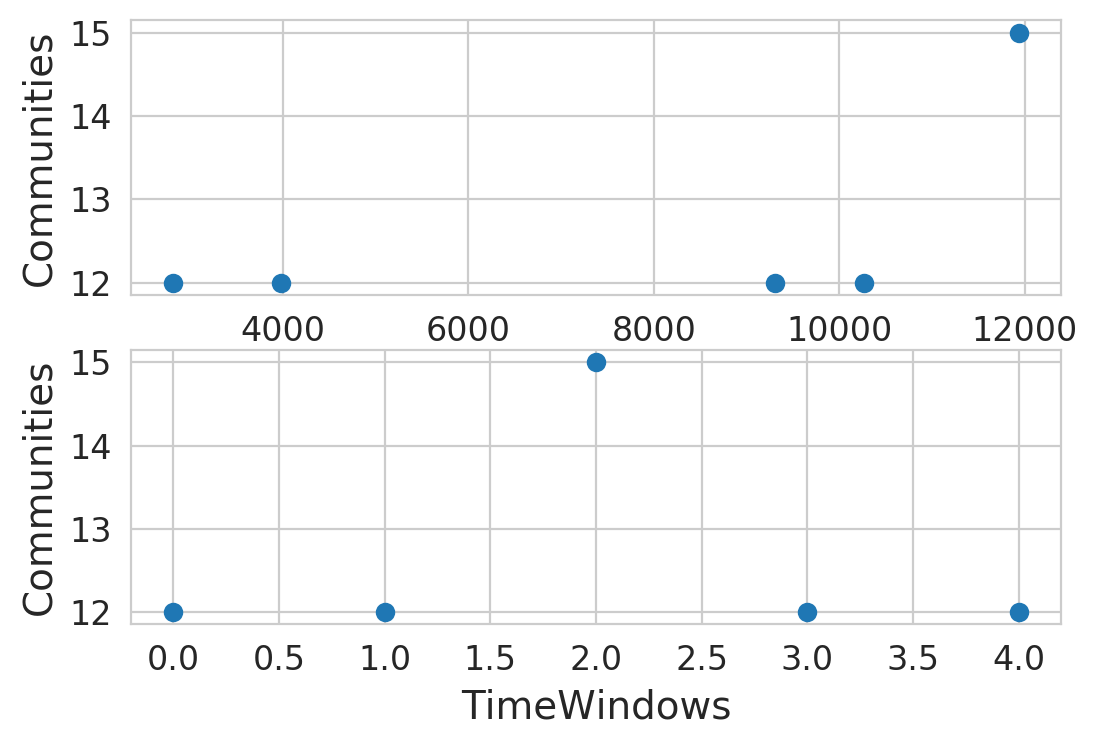

In [9]:
f,axs=plt.subplots(2,1,dpi=200)
axs[0].plot([len(i) for i in individuals],[len(ci) for ci in groupings],marker='o',
        linestyle='None')
axs[0].set_xlabel('Users in different TimeWindows')
axs[0].set_ylabel('Communities')

axs[1].plot([i for i in range(len(com_ids))],[len(ci) for ci in groupings],marker='o',
        linestyle='None')
axs[1].set_xlabel('TimeWindows')
axs[1].set_ylabel('Communities')

# MajorTrack (NOT in paper)

In [20]:
#MajorTrack is NOT used for the paper
_time_windows = [
        [-0.5, 0.5], [0.5, 1.5], [1.5, 2.5], [2.5, 3.5]
        ]
time_windows = [[10*el for el in tw] for tw in _time_windows]

s_t=time.time()
mt = MajorTrack(
        clusterings=groupings,
        individuals=individuals,
        history=0,
        timepoints=[tw[0] for tw in time_windows]
    )
mt.get_group_matchup('fraction')
e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))
# create the different instances with different history parameters
mt1 = deepcopy(mt)
mt5 = deepcopy(mt)
mt5.history =5
mt.get_dcs()
mt.get_community_group_membership()
mt.get_community_membership()
mt.get_community_coloring()
e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))
# use same colours for other visualizations
comm_colours = list(mt.comm_colours)
sp_commm_color_idx = dict(mt.sp_community_colour_idx)
#mt1.comm_colours = list(comm_colours)
#mt1.sp_community_colour_idx = dict(sp_commm_color_idx)
mt5.comm_colours = list(comm_colours)
mt5.sp_community_colour_idx = dict(sp_commm_color_idx)
e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))
# 1 step memory
# mt1.history = 1
# mt1.get_dcs()
# mt1.get_community_group_membership()
# mt1.get_community_membership()
# 5 step memory
mt5.history = 5
mt5.get_dcs()
mt5.get_community_group_membership()
mt5.get_community_membership()


e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))

Elapsed time: 24.84935294787089 min
Elapsed time: 24.91104071935018 min
Elapsed time: 24.911045436064402 min
Elapsed time: 24.911420953273772 min


In [65]:
plot_params = {
        'cluster_width': 2,
        'flux_kwargs': {'alpha': 0.2, 'lw': 0.0, 'facecolor': 'cluster'},
        'cluster_kwargs': {'alpha': 1.0, 'lw': 0.0},
        'label_kwargs': {'fontweight': 'heavy'},
        'with_cluster_labels': False,
        'cluster_label': 'group_index',
        'cluster_label_margin': (-1.6, 0.1),
        'x_axis_offset': 0.07,
        'redistribute_vertically': 4,
        'cluster_w_spacing':1000,
        'cluster_location': 'center'#,
#         'y_fix': {
#             20.0: [('4', '7'), ('0', '1'), ('4', '3')],
#             30.0: [('0', '3')]
#             }
        }

# plotting params


#rawmt = deepcopy(mt1)

# Single
# #############################################################################
# The trace back (memory) part
# the merging illustration
sankey_plot_params = dict(plot_params)
sankey_plot_params.update({
        'merged_edgecolor': 'none',  # 'xkcd:gray',
        'merged_linewidth': 1,
        'cluster_facecolor': 'community',
        'cluster_edgecolor': 'community',
#         'cluster_facecolor': col_d,
#         'cluster_edgecolor': col_d,
        'flux_facecolor': 'cluster',
        'flux_edgecolor': 'cluster',
        'cluster_label':'group_index'})
# raw image
spp_raw = deepcopy(sankey_plot_params)
spp_raw['l_size'] = 7
spp_raw['cluster_facecolor'] = 'xkcd:gray'
spp_raw['default_cluster_facecolor'] = 'xkcd:gray'

# 1 step
spp_1step = deepcopy(sankey_plot_params)
spp_1step['l_size'] = 9
# 5 step
spp_5step = deepcopy(sankey_plot_params)
spp_5step['l_size'] = 9




def _set_axis(axes, mt, spp, with_xaxis=True):
    #axes.axis('equal')
    l_size = spp.pop('l_size', 9)
    mt.get_alluvialdiagram(
            axes,
            invisible_x=not with_xaxis,
            **spp,
            )
    if with_xaxis:
        tp = [
                (t + .5*(mt.slice_widths[i])) + .5*plot_params['cluster_width']
                for i, t in enumerate(mt.timepoints)
                ]
        print(tp)
        axes.set_xticks(tp, minor=False)
        # ax_tb3.xaxis.tick_top()
        axes.set_xticklabels(
                [
                    '{}'.format(periods[idx])
                    for idx in range(len(periods))
                    ],
                minor=False,
                size=l_size
                )
        axes.tick_params(axis=u'x', which=u'both', length=0)
        plt.setp(axes.get_xticklabels(), visible=True)
    return axes


# def set_raw_axes(axes, mt=rawmt, spp=spp_raw, with_xaxis=True):
#     return _set_axis(axes, mt, spp, with_xaxis)


# def set_one_axes(axes, mt=mt1, spp=spp_1step, with_xaxis=True):
#     return _set_axis(axes, mt, spp, with_xaxis)


def set_five_axes(axes, mt=dyncl, spp=spp_5step, with_xaxis=True):
    return _set_axis(axes, mt, spp, with_xaxis)


In [60]:
with open('data/mt5_clus.pickle','rb') as f:
    dyncl=pickle.load(f)

[1.0, 11.0, 21.0, 31.0]


Text(0.5, 1.0, 'Community evolution')

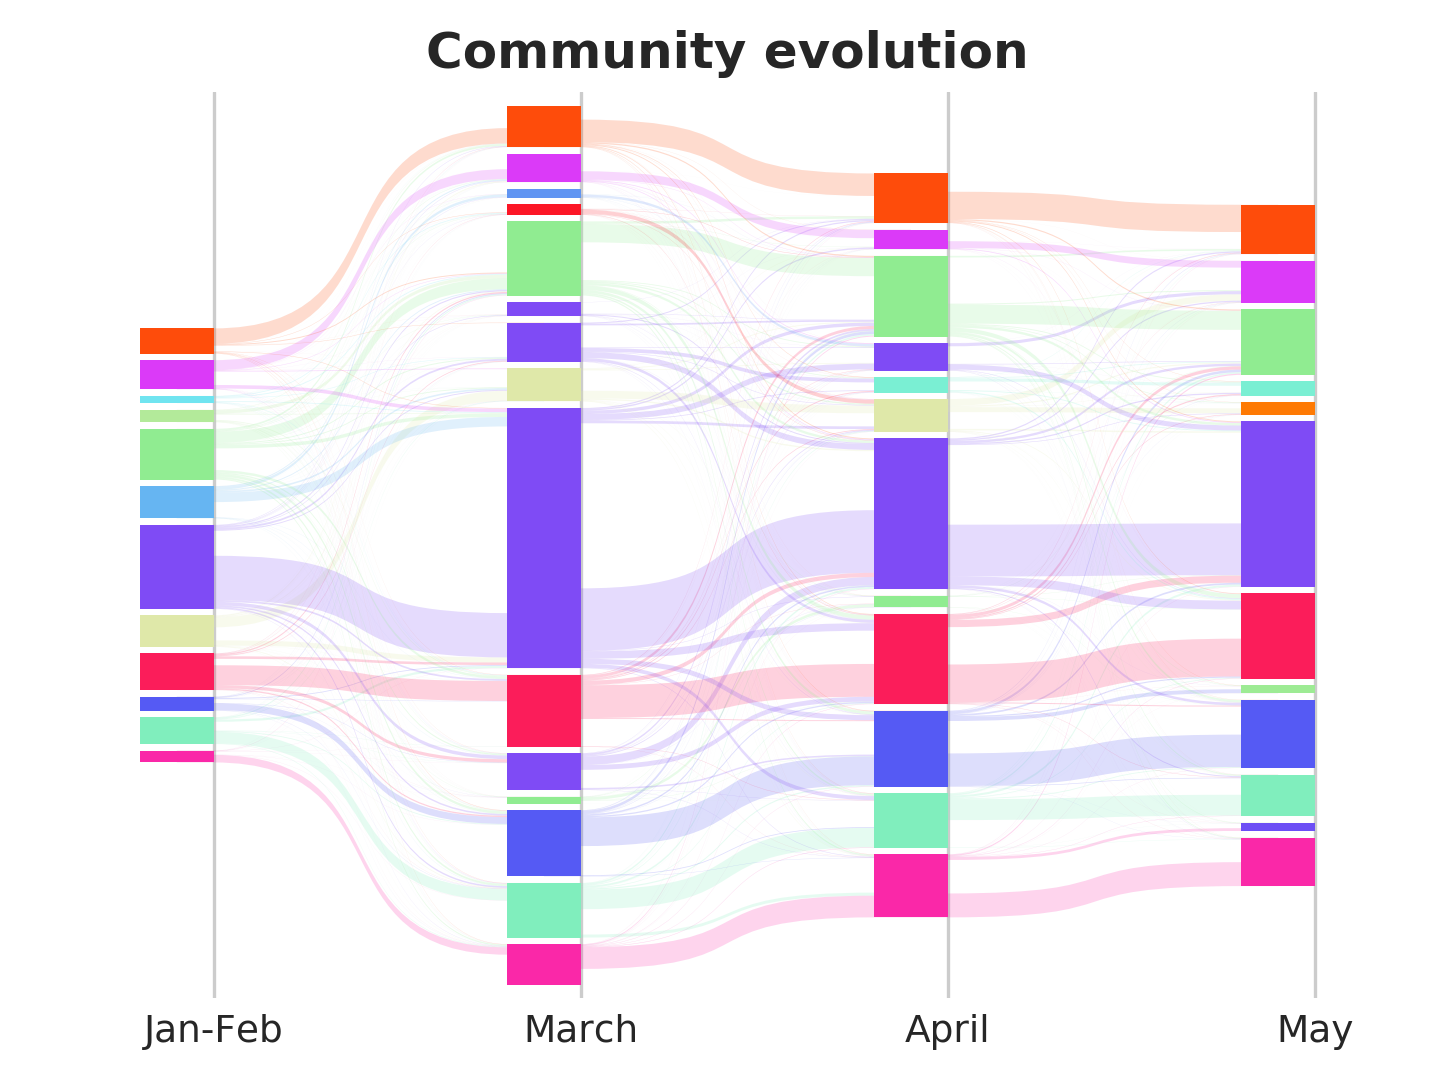

In [66]:
f=plt.figure(dpi=300)
ax_illust_five = f.add_subplot()
ax_illust_five = set_five_axes(ax_illust_five)
ax_illust_five.patch.set_visible(False)
ax_illust_five.set_title(
    'Community evolution', fontdict={'fontweight': 'heavy'})

# Manual analysis (in paper)

In [6]:
s_t=time.time()
com_of_user_tot,how_many_best_tot,com_ids_tot=destino.load_communities(
    'data/com_of_user_letters_1_30.pickle',c_ids=True,verbose=False)
periods=['Jan-Feb','March','April','May']

individuals_old=[]
groupings_old=[]
for i in range(len(com_ids)):
    #groupings.append([[us2num[u] for u in random.sample(ci,int(len(ci)/100))] for ci in com_ids[i].values() if len(ci)>10000])
    #groupings.append([random.sample(ci,int(len(ci)/10)) for ci in com_ids[i].values() if len(ci)>10000])
    groupings_old.append([ci for com,ci in com_ids[i].items() if com in alphab[:15]])
    individuals_old.append(set([item for sublist in groupings_old[i] for item in sublist]))


#min_size=100000
com_names=[]
for i in range(4):
    #com_names.append([com for com,se in com_ids[i].items() if len(se)>min_size])
    com_names.append([com for com,se in com_ids[i].items() if com in alphab[:15]])

e_t=time.time()-s_t
print('Elapsed time: {} sec'.format(e_t))

Elapsed time: 208.4486002922058 sec


In [6]:
#Considering only users in the largest 15 static communities
print(len(com_of_user_tot))

22419566


Here we compute the overlap fraction of each static community (A,...,O) respect to temporary communities (1:15) detected on 4 monthly non-overlappoing time-windows.

In [7]:
min_size=100000
superp_tot={}
superp_tot_abs={}


com_names_tot=[com for com,se in com_ids_tot.items() if len(se)>min_size]


s_t=time.time()
for i in range(4):
    superp_tot[i]=np.empty((len(com_names[i]),len(com_names_tot)))
    superp_tot_abs[i]=np.empty((len(com_names[i]),len(com_names_tot)))
    for j,c1 in tqdm(enumerate(com_names[i])):
        for k,c2 in enumerate(com_names_tot):
            inte=len(set(com_ids[i][c1]).intersection(
                set(com_ids_tot[c2])))
            superp_tot[i][j][k]=inte/len(set(com_ids_tot[c2]).intersection(individuals_old[i]))
            superp_tot_abs[i][j][k]=inte


            e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))
with open('data/superp_tot.pickle','wb') as f:
    pickle.dump(superp_tot,f)

15it [01:42,  6.86s/it]
15it [02:11,  8.79s/it]
15it [02:06,  8.41s/it]
15it [02:03,  8.25s/it]

Elapsed time: 8.07945689757665 min


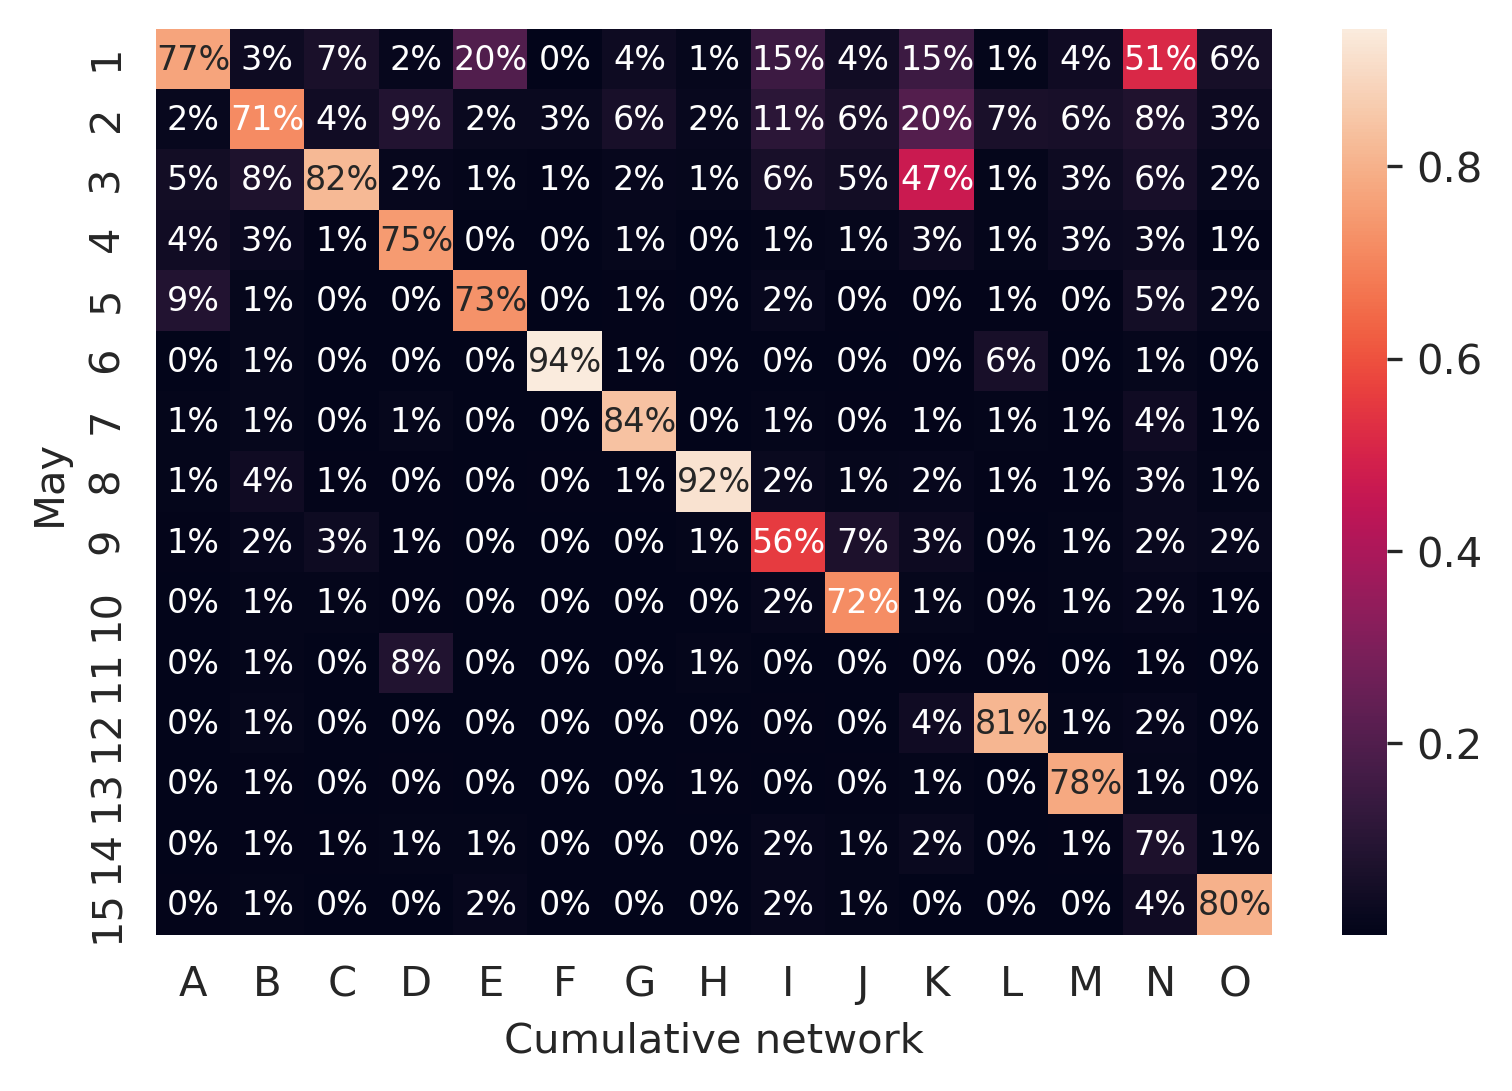

In [6]:
#SI Figure
periods=['Jan-Feb','March','April','May']
alphab=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q',
        'R','S','T','U','V','W','X','Y','Z','AA','AB','AC','AD','AE','AF','AG']
com_names_tot=alphab[:15]
with open('data/superp_tot.pickle','rb') as f:
    superp_tot=pickle.load(f)

#0:Jan-Feb, 1:March, 2:April, 3:May
i=3
superp_tot_perm=superp_tot
coms_rev=list(range(15))
coms_rev.reverse()
for j in coms_rev:
    maxes=np.argmax(superp_tot_perm[i],axis=0)
    k=maxes[j]
    superp_tot_perm[i][[j,k]]=superp_tot_perm[i][[k,j]]
    #if j>1:
    #    break
    
plt.figure(dpi=300)
sns.heatmap(superp_tot_perm[i],annot=True,fmt='.0%',annot_kws={"size": 8},
           xticklabels=com_names_tot,yticklabels=list(range(1,16)))
plt.xlabel('Cumulative network')
plt.ylabel(periods[i])
plt.savefig('images/pdfs/cum_time_'+str(i+1)+'.pdf')
plt.show()